# Machine Learning and Algorithms for Computational Social Sciences

**Project: A comparative exercise of predicting the US monetary policy rate trajectory**

**By: Luis Ortega**

In this Jupyter Notebook, I carry out a predictive exercise for the US Federal Reserve's monetary policy interest rate. The data utilized comes from the Federal Reserve Bank of St. Louis (FRED) based on the work of McCracken & Ng (2016), as the authors establish it as a convenient starting point for macroeconomic empirical analysis that requires "big data". Importantly, I follow the work of Paranhose (2021) for pre-processing the data. Furthermore, the analysis is carried out by applying and comparing different statistical and machine learning models (i.e. Lasso, Ridge, Random Forest, Neural Networks). The objective of the analysis is to determine which statistical models and which neural network models perform the best. Graphics and comments are included in each section to illustrate the analysis carried out. The Jupiter Notebook is structured as follows: (1) Data Processing, (2) Models and Application, and (3) Conclusions and further work.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
from sklearn import linear_model as lm
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

%matplotlib inline

***Section 1: Data processing***

In this section I cover the following:
- Downloading the raw data from the Federal Reserve Bank of St. Louis (FRED)
- Obtaining the transformation identifiers
- Setting up the baseline dataframe
- Applying the transformations to the variables according to McCracken & Ng (2016)
- Dealing with missing values (replacing with unconditional means)
- Standarizing the data prior to implementing models

The original data source comes from the following website, and is updated on a regular basis:
https://research.stlouisfed.org/econ/mccracken/fred-databases/

As described in the project proposal, we follow the procedure described by Livia Paranhos (2021).

In [2]:
# Downloading the data from FRED
data_url = "https://files.stlouisfed.org/"
data_url += "files/htdocs/fred-md/monthly/current.csv"
init_data = pd.read_csv(data_url)

In [3]:
# Obtaining the transformation identifiers
tcode = init_data.iloc[0, :]      # The csv file contains the transformation codes for each variable in the first row.

In [4]:
# Setting up the baseline dataframe
rawdata = init_data.iloc[1:, :]

rawdata.set_index('sasdate', inplace = True, drop = True)

rawdata = rawdata.dropna(axis = 0, how = 'all') # In case any row is filled with NaN's (last row usually), we drop it

rawdata

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6673,24.4077,23.1408,32.4565,19.6396,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/1/2021,17744.971,14406.3,125.640,1.572476e+06,644741.00000,102.0374,101.2518,101.6865,100.8504,104.7309,...,105.852,126.278,26.99,31.04,24.24,67.4,369983.50,754662.69,5607.1160,19.1586
12/1/2021,17724.218,14398.0,123.868,1.562935e+06,634393.00000,101.6402,100.7942,101.2701,100.2659,103.9276,...,106.351,126.834,27.17,31.25,24.38,70.6,370554.92,753781.25,5679.0108,21.2985
1/1/2022,17661.380,14378.0,125.739,1.580900e+06,651557.00000,102.6863,101.8134,102.4001,101.8697,106.0272,...,107.154,127.299,27.31,31.44,24.51,67.2,370997.59,752897.82,5778.1104,22.9143


In [5]:
rawdata.describe() # A visual description of the data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
count,759.000000,759.000000,759.000000,7.580000e+02,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,...,759.000000,759.000000,759.000000,759.00000,759.000000,605.000000,758.000000,758.000000,759.000000,717.000000
mean,8659.146378,7407.252964,61.294125,8.405018e+05,203148.330978,66.360375,70.677583,69.434356,77.939004,64.186907,...,59.149289,56.777408,12.005534,13.94531,11.108972,86.183802,122389.783008,327936.239855,1163.655612,19.322178
std,4474.867306,3560.985634,32.157800,3.882791e+05,166204.728690,26.388037,27.049997,27.303895,23.325281,27.797853,...,28.715693,35.486868,7.299940,8.14644,6.611203,12.453710,119603.368833,321427.393525,1255.284987,7.144688
min,2442.158000,2293.200000,17.272000,2.809324e+05,18235.773920,22.073300,23.402700,22.285800,31.568800,17.068300,...,17.777000,11.326000,2.130000,2.45000,2.040000,51.700000,6476.000000,12298.000000,71.186400,9.484400
25%,4796.394000,4279.500000,32.404000,5.117676e+05,47768.435020,44.502850,46.729650,44.648150,60.555250,40.773200,...,30.956500,20.425500,4.870000,6.49000,4.485000,76.700000,10682.250000,33260.500000,170.534900,14.293300
50%,7750.995000,6772.900000,54.495000,7.517058e+05,159547.205600,62.142300,70.497300,68.769200,79.848300,58.331100,...,63.394000,55.075000,11.490000,13.42000,10.810000,89.700000,73429.500000,184382.220000,612.698000,17.626900
75%,12702.835000,10525.250000,93.671500,1.204122e+06,343631.500000,93.164750,98.784150,97.627600,99.690800,93.250500,...,84.511000,87.695500,17.965000,19.95000,16.775000,95.100000,258720.837500,722810.487500,1934.564350,22.538100
max,21267.506000,14432.600000,126.172000,1.591781e+06,667724.000000,104.585300,110.068300,108.580800,111.295700,107.918000,...,112.115000,128.125000,27.500000,31.68000,24.710000,112.000000,374899.800000,896985.060000,5811.585900,62.964800


After setting up the raw database and dropping non-informative observations, we will proceed to define the functions to continue processing the data. These include: (i) a function to transform individual series based on the transformation code, (ii) a function that applies the previous function for the whole database, and (iii) a function that standarizes the data.

In [6]:
def transform_var(var, tcode):
    '''
    DESCRIPTION:
     This function transforms a SINGLE SERIES (in a column vector) as specified
     by a given transformation code.
     -------------------------------------------------------------------------
     INPUT:
               var     = series (in a column vector) to be transformed
               tcode   = transformation code (1-7)
     OUTPUT:
               tvar       = transformed series (as a column vector)
     -------------------------------------------------------------------------
    '''
    assert var.shape[1] == 1, 'var must contain one column'

    name = var.columns.values[0]
    var.rename(columns={name:'original'}, inplace=True)

    small = 1e-6                          # Value close to zero

    if tcode == 1:  # Level (i.e. no transformation): x(t)
        var[name] = var

    elif tcode == 2: # First difference: x(t)-x(t-1)
        var[name] = var.diff()

    elif tcode == 3: #  Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
        var[name] = var.diff().diff()

    elif tcode == 4: # Natural log: ln(x)
        if var.min()[0] > small:
            var[name] = np.log(var)

    elif tcode == 5: # First difference of natural log: ln(x)-ln(x-1)
        if var.min()[0] > small:
            var[name] = np.log(var).diff()

    elif tcode == 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
        if var.min()[0] > small:
            var[name] = np.log(var).diff().diff()

    elif tcode == 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
        var[name] = var.pct_change().diff()

    else:
        var[name] = np.nan

    return var[name]

In [7]:
def transform_data(rawdata, tcode):
    ''' 
     DESCRIPTION:
     This function transforms raw data based on each series' transformation
     code. It uses the subfunction transform_var.
     -------------------------------------------------------------------------
     INPUT:
               rawdata     = raw data
               tcode       = transformation codes for each series
     OUTPUT:
               yt          = transformed data
     -------------------------------------------------------------------------
     '''
    transformed_data = pd.DataFrame()
    variables = rawdata.columns.values     # get variable names

    for var in variables:
        x = rawdata[[var]].copy()
        transformed_data[var] = transform_var(x, int(tcode[var]))
        
    return transformed_data

In [8]:
# We apply the transformations to the data according McCracken & Ng (2016).
data = transform_data(rawdata, tcode)

# We remove the first 2 months in the DF as some series have been first differenced

data = data.iloc[2:, :]

C:\Users\luiso\AppData\Local\Temp/ipykernel_21328/3461516482.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_data[var] = transform_var(x, int(tcode[var]))


In [9]:
# We replace missing values with the unconditional mean of each series
data = data.fillna(value = data.mean(), axis = 0)

In [10]:
def standarize(data):
    '''
     DESCRIPTION
     This function standarizes a given set of series with the unconditional
     mean and standard deviatoin.
     -------------------------------------------------------------------------
     INPUTS
               data      = set of series to be transformed (one series per
                         column); no missing values;
               
     OUTPUTS
               final    = standarized dataset
               mut     = matrix containing the values subtracted from data
                         during the transformation
               std     = matrix containing the values that data was divided by
                         during the transformation
     -------------------------------------------------------------------------
    '''
    mut = data.mean()
    std = data.std()

    final = (data - mut) / std

    return final, mut, std

In [11]:
database, mut, std = standarize(data)

In [12]:
database # A visual representation of the resulting database to be utilized.

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
3/1/1959,0.313909,0.805380,0.795348,-4.452228e-01,0.225655,1.209161,0.411264,0.264458,-0.145966,0.525880,...,-0.193022,0.161472,-0.004887,-0.901277,1.014344,-1.035228e-17,0.206179,0.208613,-1.368110,0.000000
4/1/1959,0.319164,0.754706,-0.731665,1.398973e+00,-0.260772,1.876626,1.246394,1.152570,1.326989,0.125211,...,0.218532,1.092832,-0.004836,1.350651,-1.029898,-1.035228e-17,0.508397,0.339617,2.303556,0.000000
5/1/1959,0.259151,0.684220,1.099037,3.621493e-01,0.192967,1.272973,0.635903,0.695826,0.302740,0.549093,...,-0.286625,-1.212253,-0.004786,-0.452339,-1.015108,-1.035228e-17,0.118056,0.101722,-1.418937,0.000000
6/1/1959,0.040719,0.090118,0.128143,-1.788906e-01,0.272567,-0.087190,0.511693,0.469575,-0.594673,0.158221,...,0.545837,1.305925,-1.157178,0.441951,1.009574,-1.035228e-17,0.407400,0.454298,-1.133276,0.000000
7/1/1959,-0.262351,-0.519473,-0.706788,7.818431e-01,-0.320484,-2.587879,-0.078547,0.572772,1.082577,0.532524,...,-0.211950,-0.064813,0.000586,-0.446854,-1.010241,-1.035228e-17,-0.194819,-0.050685,2.711382,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/1/2021,-0.242098,-0.392629,-0.398887,-7.292322e-02,0.077659,0.559967,0.769005,0.601403,0.736059,0.163863,...,-0.427923,1.065931,0.370641,-0.359877,-0.002100,-1.269372e+00,0.128593,0.112097,-0.581193,-0.023526
12/1/2021,-0.310048,-0.488886,-1.967912,-6.555971e-01,-1.321044,-0.584195,-0.651594,-0.564669,-0.692919,-0.308135,...,-0.634770,-0.362222,0.643037,0.425045,0.603356,9.685104e-01,0.013886,0.018333,-0.116719,0.284236
1/1/2022,-0.505553,-0.621603,1.448506,7.280279e-01,1.385623,0.808876,0.816139,0.835212,1.347268,0.544476,...,0.463171,-0.460627,-0.377273,-0.075143,-0.093169,-1.000826e+00,-0.015235,-0.000443,0.420641,0.516621


I create some graphs to visually observe how the original target variable looks, and how the post-transformation series looks.

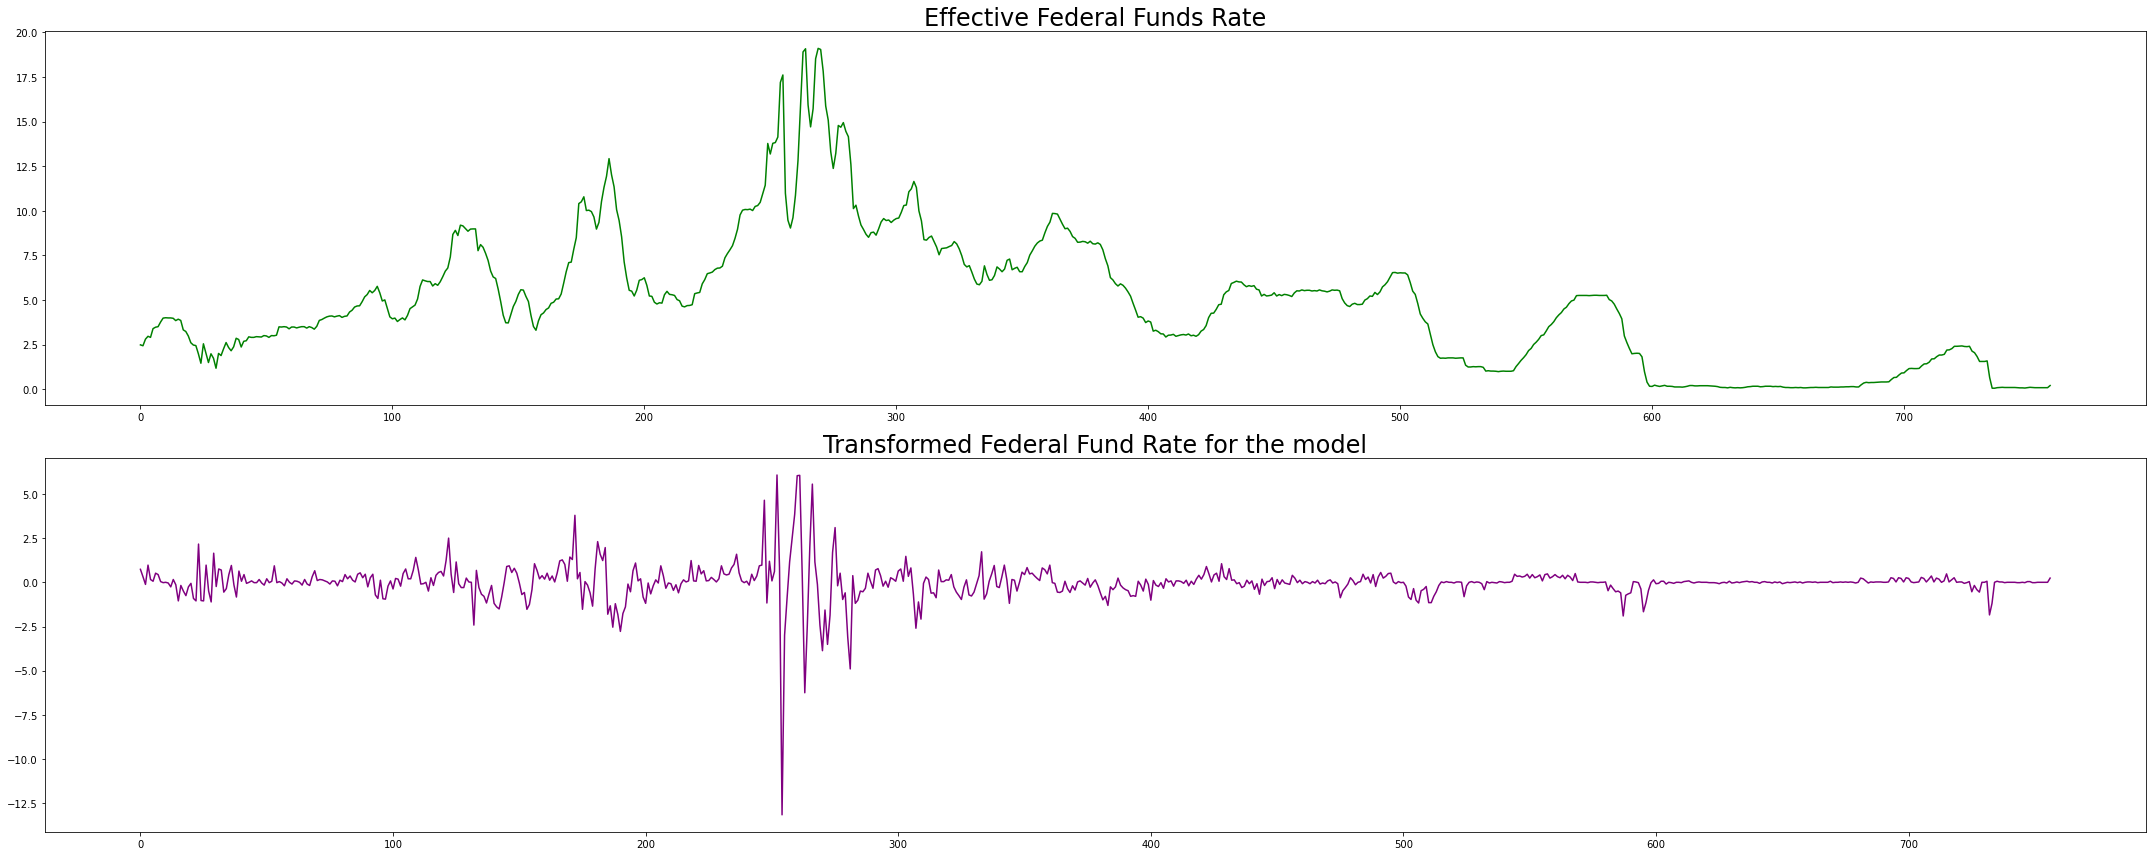

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (30,12))

# Still pending how to include x axis labels without clustering the dates (becomes unreadable)
ax1.plot(rawdata['FEDFUNDS'].values, color = 'green')
ax1.set_title('Effective Federal Funds Rate', fontdict = {'fontsize': 24})
ax2.plot(database['FEDFUNDS'].values, color = 'purple')
ax2.set_title('Transformed Federal Fund Rate for the model', fontdict = {'fontsize': 24})


fig.tight_layout()

***Section 2: Models and application***

In this section I cover the following:
- Estimating and comparing the described models statistical models (Lasso, Ridge, RandomForest) in terms of the mean absolute error.
- Estimating and comparing the described neural network models (MLP, Conv1D, LSTM, Stacked LSTM, Conv1D-LSTM).

Prior to entering each sub-section, I define the training, validation and testing splits. Each sub-section will be covered separately.

In terms of the model specification, each model will include all of the variables in the database as features except for the target variable, the Effective Federal Funds Rate.

In [14]:
# We create the splits for training, validation and testing.
# IMPORTANT: the Neural Network Models use a validation data while optimizing, whereas the other models do not explicitly distinguish on a specific validation set.
# Therefore, we will define two subsets to be used:
# First split of training and testing for non-neural network models (80% - 20%) called temp and test
# Second split of training and testing for neural-networks (80% - 20%) from the test split, called train and val.
# I will create the second split later in the notebook.

X = database.loc[:, database.columns != 'FEDFUNDS']
y = database['FEDFUNDS']

# First Split: Temp and Test data (for non-neural network models)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [15]:
# I create dictionaries to store mean_absolute_error metrics on validation and test data sets.
stat_val_performance = {}
stat_performance = {}

**Section 2.1: Statistical models**

Here we will estimate several models from different statistical branches. We will compare their performances in predicting the monetary policy rate movements.

The first model will be a Lasso Regression, which is a modified linear regression which includes an L1 norm term and a regularization parameter to the regression. Effectively, the additional term sets coefficients to zero for features that are not informative about the target.

The second model will be a Ridge Regression. The main difference to the Lasso regression is the inclusion of an L2 norm term instead of the L1 term to the regression. The coefficients here are shrinked wereas the Lasso regression sets them to 0.

The last model will be a Random Forest Regression. As seen in class, this model build up on regression trees by randomizing on the features chosen for branching and subsets of data. This helps improves predictions and reduces their volatility.

For all of the models we will intend to apply a common accuracy metric, the mean_absolute error.

*Lasso Regression*

In [16]:
# Setting up the relevant parameters for a cross validation of the lasso model

#alphas_lasso = np.linspace(0.01, 1, 101) #This was the initial run, so I restricted the domain further to zoom-in on the results
alphas_lasso = np.linspace(0.01, 0.3, 101)

lasso_model = lm.Lasso(random_state = 1111)

grid_lasso = dict()
grid_lasso['alpha'] = alphas_lasso

scorer = make_scorer(mean_absolute_error, greater_is_better = False)

In [17]:
%%time

# Running the Grid Search and saving the results
grid_1 = GridSearchCV(estimator = lasso_model, param_grid = grid_lasso, scoring = scorer, cv = 5)

# we fit with X_temp and y_temp since this split includes both the training and validation data.
lasso_results = grid_1.fit(X_temp, y_temp)

lasso_mean_mae = lasso_results.cv_results_['mean_test_score']

lasso_bscore = lasso_results.best_score_
lasso_bparam = lasso_results.best_params_

best_lasso = lasso_results.best_estimator_

Wall time: 2.38 s


The best score is: -0.3754137996442607 and it is obtained when alpha = 0.0448


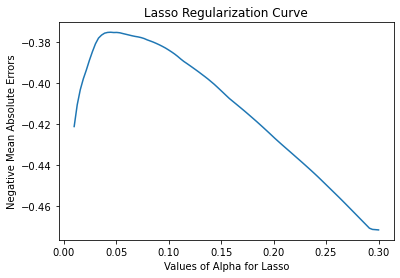

In [18]:
# We plot the regularization function for the lasso regression.
plt.plot(alphas_lasso, lasso_mean_mae)
plt.xlabel('Values of Alpha for Lasso')
plt.ylabel('Negative Mean Absolute Errors')
plt.title('Lasso Regularization Curve')

print('The best score is: ' + str(lasso_bscore) + ' and it is obtained when alpha = ' + str(lasso_bparam['alpha']))

The mean absolute error for the random forest forecast on the test is -0.10729612210072605


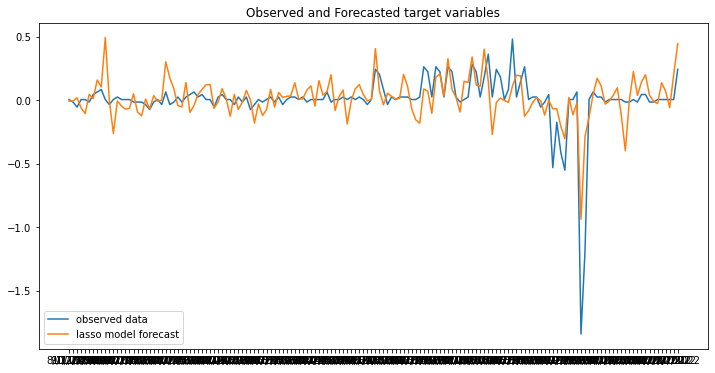

In [19]:
# We plot the results from the best lasso model against the target variable in the test set
y_pred_lasso = best_lasso.predict(X_test)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso) * (-1)

plt.figure(figsize = (12, 6))
plt.plot(y_test, label = 'observed data')
plt.plot(y_pred_lasso, label = 'lasso model forecast')
plt.title('Observed and Forecasted target variables')
plt.legend()

print('The mean absolute error for the random forest forecast on the test is ' + str(lasso_mae))

stat_val_performance['Lasso'] = lasso_bscore
stat_performance['Lasso'] = lasso_mae

non_zero_lasso = np.count_nonzero(best_lasso.coef_)

*Ridge Regression*

In [20]:
# Setting up the relevant parameters for a cross validation of the ridge model

#alphas_ridge = np.linspace(0.001, 1000, 1000) initial run to see alpha's dimension
alphas_ridge = np.linspace(200, 400, 1000)

ridge_model = lm.Ridge(random_state = 1111)

grid_ridge = dict()
grid_ridge['alpha'] = alphas_ridge

In [21]:
%%time

# Running the Grid Search and saving the results
grid_2 = GridSearchCV(estimator = ridge_model, param_grid = grid_ridge, scoring = scorer, cv = 5)

# we fit with X_temp and y_temp since this split includes both the training and validation data.
ridge_results = grid_2.fit(X_temp, y_temp)

ridge_mean_mae = ridge_results.cv_results_['mean_test_score']

ridge_bscore = ridge_results.best_score_
ridge_bparam = ridge_results.best_params_

best_ridge = ridge_results.best_estimator_

Wall time: 22.6 s


The best score is: -0.4470887114914011 and it is obtained when alpha = 299.2992992992993


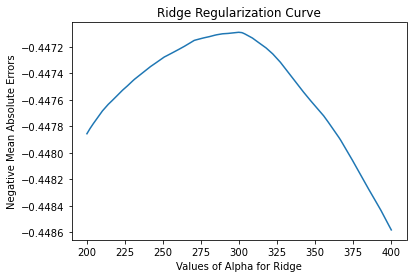

In [22]:
# We plot the regularization function for the lasso regression.
plt.plot(alphas_ridge, ridge_mean_mae)
plt.xlabel('Values of Alpha for Ridge')
plt.ylabel('Negative Mean Absolute Errors')
plt.title('Ridge Regularization Curve')

print('The best score is: ' + str(ridge_bscore) + ' and it is obtained when alpha = ' + str(ridge_bparam['alpha']))

The mean absolute error for the random forest forecast on the test is -0.1757482695147196


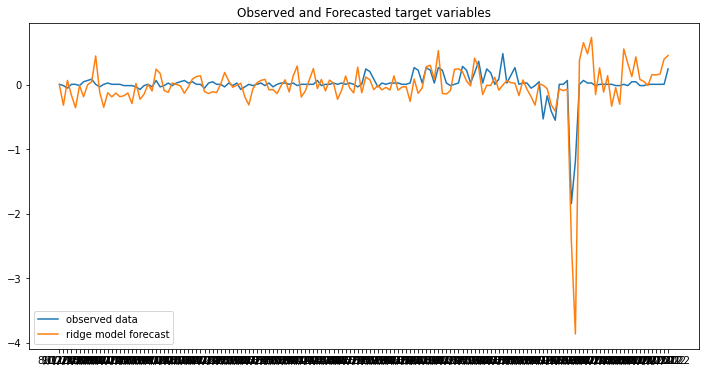

In [23]:
# We plot the results from the best ridge model against the target variable in the test set
y_pred_ridge = best_ridge.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge) * (-1)

plt.figure(figsize = (12, 6))
plt.plot(y_test, label = 'observed data')
plt.plot(y_pred_ridge, label = 'ridge model forecast')
plt.title('Observed and Forecasted target variables')
plt.legend()

print('The mean absolute error for the random forest forecast on the test is ' + str(ridge_mae))

stat_val_performance['Ridge'] = ridge_bscore
stat_performance['Ridge'] = ridge_mae

*Random Forest Regression*

In [24]:
# Setting up the relevant parameters for a cross validation of the Random Forest
rfr_model = RFR(random_state = 1111)

# Initial run was:
#estimators = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
#depth = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# With this grid, the runtime was 9 mins and 21 secs. I zoomed in the grid towards the optimal parameters of the first run with a smaller grid.  
estimators = np.array([30, 35, 40, 45, 50])
depth = np.array([10, 15, 20, 25, 30])

grid_rfr = dict()
grid_rfr['n_estimators'] = estimators
grid_rfr['max_depth'] = depth

In [25]:
%%time

# Running the Grid Search and saving the results
grid_3 = GridSearchCV(estimator = rfr_model, param_grid = grid_rfr, scoring = scorer, cv = 5)

# we fit with X_temp and y_temp since this split includes both the training and validation data.
rfr_results = grid_3.fit(X_temp, y_temp)

rfr_mean_mae = rfr_results.cv_results_['mean_test_score']

rfr_bscore = rfr_results.best_score_
rfr_bparam = rfr_results.best_params_

best_rfr = rfr_results.best_estimator_

Wall time: 1min 38s


The best score is: -0.4672845477826636 and it is obtained when the number of estimators = 40 and the max depth = 15


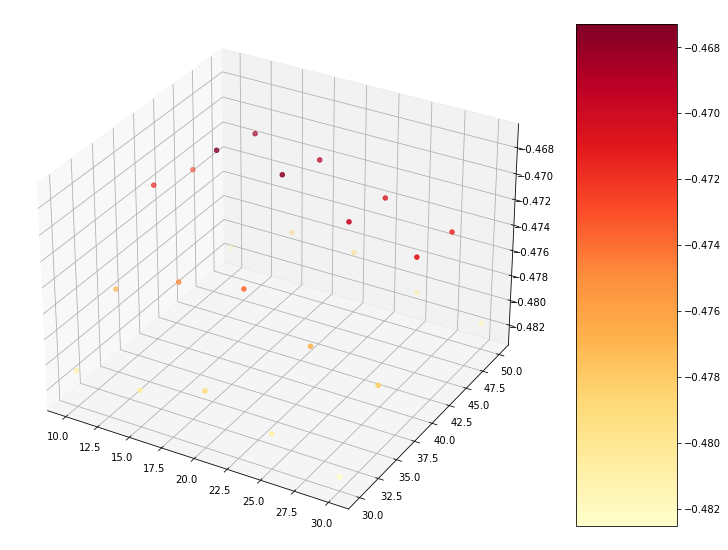

In [26]:
fig = plt.figure(figsize = (12, 12))

ax = plt.axes(projection = '3d')

xdata = rfr_results.cv_results_['param_max_depth'].compressed()
ydata = rfr_results.cv_results_['param_n_estimators'].compressed()
zdata = rfr_mean_mae

color_map = plt.get_cmap('YlOrRd')
scat = ax.scatter3D(xdata, ydata, zdata, c = zdata.flatten(), cmap = color_map)
fig.colorbar(scat, shrink = 1, aspect = 5)

print('The best score is: ' + str(rfr_bscore) + ' and it is obtained when the number of estimators = ' + str(rfr_bparam['n_estimators']) + ' and the max depth = ' + str(rfr_bparam['max_depth']))

The mean absolute error for the random forest forecast on the test is -0.11795341946923621


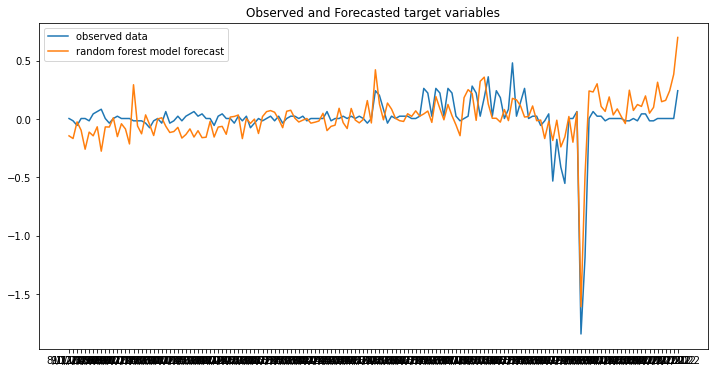

In [27]:
# We plot the results from the best Random Forest model against the target variable in the test set
y_pred_rfr = best_rfr.predict(X_test)
rfr_mae = mean_absolute_error(y_test, y_pred_rfr) * (-1)

plt.figure(figsize = (12, 6))
plt.plot(y_test, label = 'observed data')
plt.plot(y_pred_rfr, label = 'random forest model forecast')
plt.title('Observed and Forecasted target variables')
plt.legend()

print('The mean absolute error for the random forest forecast on the test is ' + str(rfr_mae))

stat_val_performance['RFR'] = rfr_bscore
stat_performance['RFR'] = rfr_mae

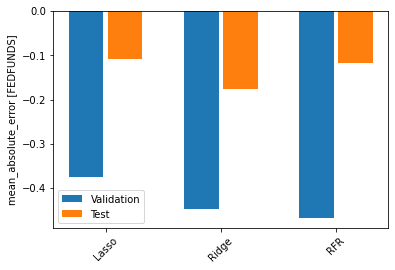

In [28]:
# Bar plot to compare Lasso and RFR mean_absolute_errors (expressed in negative as greater_is_better = False)
x = np.arange(len(stat_performance))
width = 0.3
metric_name = 'mean_absolute_error'


plt.ylabel('mean_absolute_error [FEDFUNDS]')
plt.bar(x - 0.17, stat_val_performance.values(), width, label = 'Validation')
plt.bar(x + 0.17, stat_performance.values(), width, label = 'Test')
plt.xticks(ticks = x, labels = stat_performance.keys(),
           rotation = 45)
_ = plt.legend()

As we can observer, between the statistical models the Lasso model seems to perform better than the Ridge Regression and RandomForest Regression both in the validation set and the test set. A look into the Lasso Regression parameter reveals that only 10 features were found important for the loss minimization. The results can be seen below.

In [29]:
relevant = best_lasso.coef_.nonzero()
LassoCoef = pd.DataFrame(best_lasso.coef_, index = list(X))
values = LassoCoef.iloc[relevant]
values

,0
IPNMAT,0.032960
UEMP27OV,-0.005159
MANEMP,0.015457
USGOVT,0.014838
CP3Mx,0.821707
TB3MS,0.058410
GS10,-0.015281
AAA,-0.099929
COMPAPFFx,-0.119200
INVEST,-0.052776


**Section 2.2: Neural Network Models**

Since we are dealing with time series, we will introduce the Window Generator helper class in order to effectively account for the predictive task that the neural networks must carry out. In particular, since the objective is to carry out predictions into the future, we must explicitly define an input window with the following features: the width (number of time steps) of the input and label windows, the time offset between them, and which features are used as inputs, labels, or both. In my own words, we must define on how long of a time period a model will be run (input window), how further into the future the prediction will be carried out (offset), and how many period ahead of this offset will the prediction be computed for (label width).

In [30]:
# Splitting the data according to the same splits carried out for the statistical models.

n = database.shape[0]
num_features = database.shape[1]

# Training data
train_n = int(n*0.64)
train_df = database.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.16)
val_df = database.iloc[train_n:train_n+val_n, :]

# Testing data
test_df = database.iloc[train_n+val_n:, :]

In [31]:
class WindowGenerator():

    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns)
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join(
            [
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ], axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='FEDFUNDS', max_subplots=3):
    
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices, predictions[n, :, 0],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )

            if n == 0:
                plt.legend()

        plt.xlabel('Months')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = True,
            batch_size = 48,
            seed = 1111, # I set a seed for tracking/replicating purposes, but I understand in general it could be left random.
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result

        return result

In [32]:
# Defining the relevant windows for MLP, Conv1D and RNN (LSTM)
INPUT_WIDTH = 24
LABEL_WIDTH = 1
SHIFT = 1

eval_window = WindowGenerator(
    input_width = INPUT_WIDTH, 
    label_width = LABEL_WIDTH,
    shift = SHIFT, 
    label_columns = ["FEDFUNDS"]
)

wide_window = WindowGenerator(
    input_width = INPUT_WIDTH, 
    label_width = 24, 
    shift = SHIFT,
    label_columns = ["FEDFUNDS"]
)


CONV_WIDTH = 12

conv_window = WindowGenerator(
    input_width = CONV_WIDTH,
    label_width = LABEL_WIDTH,
    shift = SHIFT,
    label_columns = ["FEDFUNDS"]
)

wide_conv_window = WindowGenerator(
    input_width = 24 + (CONV_WIDTH - 1),
    label_width = 24,
    shift = SHIFT,
    label_columns = ["FEDFUNDS"]
)

In [33]:
MAX_EPOCHS = 150

def compile_and_fit(model, window, patience = 5):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = patience,
        mode = 'min',
        verbose = 1
    )

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = [tf.keras.metrics.MeanAbsoluteError()]
    )


    history = model.fit(
        window.train, epochs = MAX_EPOCHS,
        validation_data = window.val,
        #callbacks = [early_stopping], # I disable callback in order to observe the full epochs for the models in several runs.
    )

    return history

In [34]:
val_performance = {}
performance = {}

*Multi-Step-Dense MLP*

In [98]:
%%time
mlp_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 8, activation = 'relu', kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = 1),
        tf.keras.layers.Reshape([1, -1])
    ]
)

history_mlp = compile_and_fit(mlp_model, conv_window)

val_performance['MLP'] = mlp_model.evaluate(conv_window.val)
performance['MLP'] = mlp_model.evaluate(conv_window.test)

Epoch 1/150
10/10 [==============================] - 1s 16ms/step - loss: 7.3294 - mean_absolute_error: 1.2564 - val_loss: 4.8761 - val_mean_absolute_error: 0.8226
Epoch 2/150
10/10 [==============================] - 0s 6ms/step - loss: 6.1550 - mean_absolute_error: 1.0225 - val_loss: 4.8284 - val_mean_absolute_error: 0.8755
Epoch 3/150
10/10 [==============================] - 0s 7ms/step - loss: 5.4782 - mean_absolute_error: 0.9465 - val_loss: 4.7171 - val_mean_absolute_error: 0.8896
Epoch 4/150
10/10 [==============================] - 0s 6ms/step - loss: 5.0260 - mean_absolute_error: 0.8354 - val_loss: 4.7246 - val_mean_absolute_error: 0.9037
Epoch 5/150
10/10 [==============================] - 0s 6ms/step - loss: 4.3372 - mean_absolute_error: 0.7102 - val_loss: 4.6917 - val_mean_absolute_error: 0.9178
Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 4.0854 - mean_absolute_error: 0.6650 - val_loss: 4.5306 - val_mean_absolute_error: 0.9087
Epoch 7/150
10/10 [==

10/10 [==============================] - 0s 6ms/step - loss: 1.3304 - mean_absolute_error: 0.4341 - val_loss: 1.5105 - val_mean_absolute_error: 0.6346
Epoch 52/150
10/10 [==============================] - 0s 6ms/step - loss: 1.5785 - mean_absolute_error: 0.4726 - val_loss: 1.3531 - val_mean_absolute_error: 0.5967
Epoch 53/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2526 - mean_absolute_error: 0.4478 - val_loss: 1.3615 - val_mean_absolute_error: 0.5962
Epoch 54/150
10/10 [==============================] - 0s 6ms/step - loss: 1.3667 - mean_absolute_error: 0.4448 - val_loss: 1.2354 - val_mean_absolute_error: 0.5705
Epoch 55/150
10/10 [==============================] - 0s 6ms/step - loss: 1.5160 - mean_absolute_error: 0.4432 - val_loss: 1.4054 - val_mean_absolute_error: 0.5869
Epoch 56/150
10/10 [==============================] - 0s 6ms/step - loss: 1.4142 - mean_absolute_error: 0.4217 - val_loss: 1.1589 - val_mean_absolute_error: 0.5336
Epoch 57/150
10/10 [=========

10/10 [==============================] - 0s 6ms/step - loss: 1.3472 - mean_absolute_error: 0.4807 - val_loss: 1.0563 - val_mean_absolute_error: 0.4973
Epoch 102/150
10/10 [==============================] - 0s 5ms/step - loss: 1.2456 - mean_absolute_error: 0.4645 - val_loss: 1.1573 - val_mean_absolute_error: 0.5219
Epoch 103/150
10/10 [==============================] - 0s 5ms/step - loss: 1.2409 - mean_absolute_error: 0.4685 - val_loss: 1.0400 - val_mean_absolute_error: 0.5015
Epoch 104/150
10/10 [==============================] - 0s 5ms/step - loss: 1.4409 - mean_absolute_error: 0.4490 - val_loss: 1.4470 - val_mean_absolute_error: 0.6075
Epoch 105/150
10/10 [==============================] - 0s 6ms/step - loss: 1.3230 - mean_absolute_error: 0.4795 - val_loss: 0.9905 - val_mean_absolute_error: 0.4851
Epoch 106/150
10/10 [==============================] - 0s 5ms/step - loss: 1.0558 - mean_absolute_error: 0.4415 - val_loss: 0.9801 - val_mean_absolute_error: 0.4841
Epoch 107/150
10/10 [===

3/3 [==============================] - 0s 1ms/step - loss: 1.1722 - mean_absolute_error: 0.4661
Wall time: 13.1 s


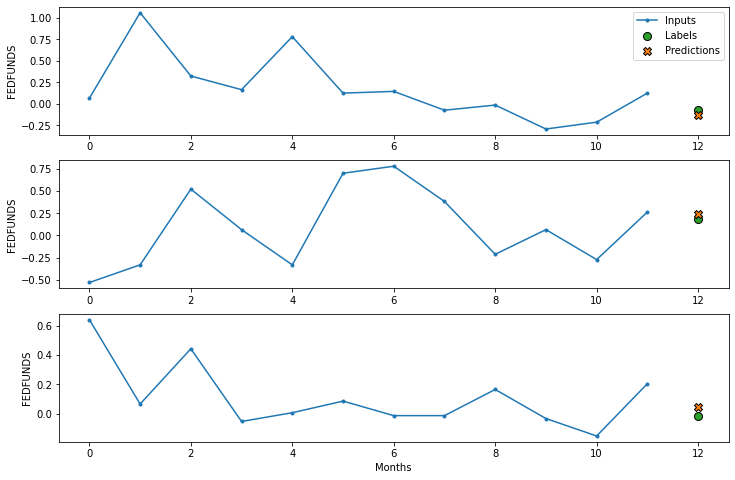

In [99]:
conv_window.plot(mlp_model, max_subplots = 3)

In [100]:
# The main downside of this approach is that the resulting model can only be executed on input windows of exactly this shape. 
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', mlp_model(conv_window.example[0]).shape)

# If we extend the window to show for multiple input labels, the output dimensions of the MLP are unable to be observed.
# Uncomment the below code to observe the error (axis of input shape missmatch)
# For further details, one can look at: https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network (Dense and Multi-step Dense)
#print('Input shape:', wide_conv_window.example[0].shape)
#print('Output shape:', mlp_model(wide_conv_window.example[0]).shape)

Input shape: (48, 12, 127)
Output shape: (48, 1, 1)


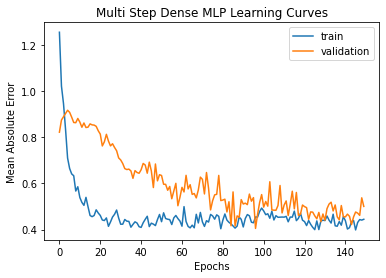

In [101]:
# We plot the learning curves of the model based on the history from fitting the model.
plt.plot(history_mlp.history['mean_absolute_error'])
plt.plot(history_mlp.history['val_mean_absolute_error'])
plt.title('Multi Step Dense MLP Learning Curves')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

**Convolutional Neural Network: Conv1D**

In [102]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters = 12, kernel_size = (CONV_WIDTH,), activation = "relu", kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = 8, activation = "relu", kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1'),
        tf.keras.layers.Dense(units = 1),
    ]
)

history_conv1d = compile_and_fit(conv_model, conv_window)

val_performance['Conv1D'] = conv_model.evaluate(conv_window.val)
performance['Conv1D'] = conv_model.evaluate(conv_window.test)

Epoch 1/150
10/10 [==============================] - 1s 16ms/step - loss: 8.1509 - mean_absolute_error: 1.0098 - val_loss: 6.4792 - val_mean_absolute_error: 0.7511
Epoch 2/150
10/10 [==============================] - 0s 6ms/step - loss: 7.1580 - mean_absolute_error: 0.7743 - val_loss: 6.3922 - val_mean_absolute_error: 0.7723
Epoch 3/150
10/10 [==============================] - 0s 6ms/step - loss: 6.5714 - mean_absolute_error: 0.6837 - val_loss: 6.2031 - val_mean_absolute_error: 0.7480
Epoch 4/150
10/10 [==============================] - 0s 6ms/step - loss: 6.2705 - mean_absolute_error: 0.6674 - val_loss: 5.8524 - val_mean_absolute_error: 0.7149
Epoch 5/150
10/10 [==============================] - 0s 6ms/step - loss: 5.7807 - mean_absolute_error: 0.6188 - val_loss: 5.6033 - val_mean_absolute_error: 0.7126
Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 5.4071 - mean_absolute_error: 0.5966 - val_loss: 5.4291 - val_mean_absolute_error: 0.7159
Epoch 7/150
10/10 [==

10/10 [==============================] - 0s 6ms/step - loss: 1.3663 - mean_absolute_error: 0.4442 - val_loss: 1.1858 - val_mean_absolute_error: 0.4086
Epoch 52/150
10/10 [==============================] - 0s 6ms/step - loss: 1.3189 - mean_absolute_error: 0.4453 - val_loss: 1.1518 - val_mean_absolute_error: 0.3923
Epoch 53/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2940 - mean_absolute_error: 0.4229 - val_loss: 1.1941 - val_mean_absolute_error: 0.4036
Epoch 54/150
10/10 [==============================] - 0s 6ms/step - loss: 1.3534 - mean_absolute_error: 0.4417 - val_loss: 1.1629 - val_mean_absolute_error: 0.3872
Epoch 55/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2393 - mean_absolute_error: 0.4219 - val_loss: 1.1066 - val_mean_absolute_error: 0.3877
Epoch 56/150
10/10 [==============================] - 0s 6ms/step - loss: 1.4750 - mean_absolute_error: 0.4604 - val_loss: 1.2115 - val_mean_absolute_error: 0.4022
Epoch 57/150
10/10 [=========

10/10 [==============================] - 0s 6ms/step - loss: 1.4773 - mean_absolute_error: 0.4826 - val_loss: 1.2513 - val_mean_absolute_error: 0.4740
Epoch 102/150
10/10 [==============================] - 0s 6ms/step - loss: 1.4807 - mean_absolute_error: 0.4512 - val_loss: 1.1415 - val_mean_absolute_error: 0.4272
Epoch 103/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2779 - mean_absolute_error: 0.4430 - val_loss: 1.3872 - val_mean_absolute_error: 0.5031
Epoch 104/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2310 - mean_absolute_error: 0.4305 - val_loss: 1.2793 - val_mean_absolute_error: 0.4789
Epoch 105/150
10/10 [==============================] - 0s 6ms/step - loss: 1.2468 - mean_absolute_error: 0.4305 - val_loss: 1.2274 - val_mean_absolute_error: 0.4627
Epoch 106/150
10/10 [==============================] - 0s 6ms/step - loss: 1.3013 - mean_absolute_error: 0.4397 - val_loss: 1.1315 - val_mean_absolute_error: 0.4568
Epoch 107/150
10/10 [===

3/3 [==============================] - 0s 997us/step - loss: 1.3996 - mean_absolute_error: 0.4777


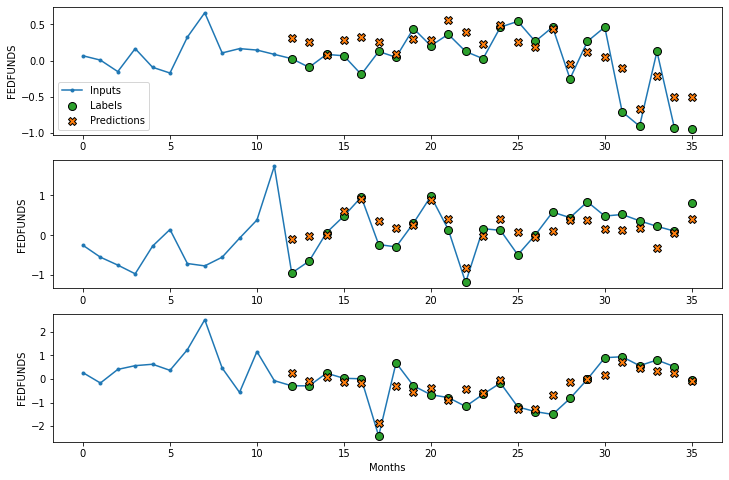

In [103]:
wide_conv_window.plot(conv_model, max_subplots = 3)

In [104]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Input shape: (48, 12, 127)
Output shape: (48, 1, 1)


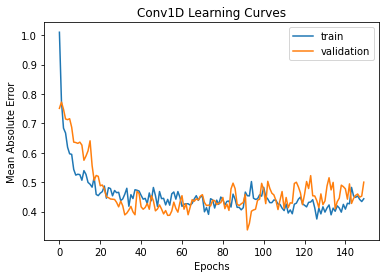

In [105]:
plt.plot(history_conv1d.history['mean_absolute_error'])
plt.plot(history_conv1d.history['val_mean_absolute_error'])
plt.title('Conv1D Learning Curves')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

**Recurrent Neural Network: LTSM**

In [106]:
%%time
lstm_model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(64, activation = 'relu', kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1', recurrent_dropout = 0.2, return_sequences = False),
        tf.keras.layers.Dense(units = 32, activation = "relu"),
        tf.keras.layers.Dense(units = 1),
        tf.keras.layers.Reshape([1, -1])
    ]
)

history_lstm = compile_and_fit(lstm_model, eval_window)

val_performance['Lstm'] = lstm_model.evaluate(eval_window.val)
performance['Lstm'] = lstm_model.evaluate(eval_window.test)

Epoch 1/150
10/10 [==============================] - 2s 34ms/step - loss: 21.4321 - mean_absolute_error: 0.6818 - val_loss: 18.6862 - val_mean_absolute_error: 0.3496
Epoch 2/150
10/10 [==============================] - 0s 15ms/step - loss: 18.6402 - mean_absolute_error: 0.5890 - val_loss: 16.2432 - val_mean_absolute_error: 0.3022
Epoch 3/150
10/10 [==============================] - 0s 15ms/step - loss: 16.1794 - mean_absolute_error: 0.5521 - val_loss: 14.0207 - val_mean_absolute_error: 0.3141
Epoch 4/150
10/10 [==============================] - 0s 15ms/step - loss: 13.9034 - mean_absolute_error: 0.5331 - val_loss: 12.0026 - val_mean_absolute_error: 0.3051
Epoch 5/150
10/10 [==============================] - 0s 15ms/step - loss: 11.8143 - mean_absolute_error: 0.5066 - val_loss: 10.1480 - val_mean_absolute_error: 0.2989
Epoch 6/150
10/10 [==============================] - 0s 15ms/step - loss: 10.0106 - mean_absolute_error: 0.4964 - val_loss: 8.5234 - val_mean_absolute_error: 0.2956
Epoch

10/10 [==============================] - 0s 15ms/step - loss: 1.1969 - mean_absolute_error: 0.4055 - val_loss: 1.0200 - val_mean_absolute_error: 0.3217
Epoch 51/150
10/10 [==============================] - 0s 15ms/step - loss: 1.1962 - mean_absolute_error: 0.4072 - val_loss: 1.0072 - val_mean_absolute_error: 0.3097
Epoch 52/150
10/10 [==============================] - 0s 15ms/step - loss: 1.3325 - mean_absolute_error: 0.4384 - val_loss: 1.0642 - val_mean_absolute_error: 0.3427
Epoch 53/150
10/10 [==============================] - 0s 15ms/step - loss: 1.3510 - mean_absolute_error: 0.4474 - val_loss: 1.0908 - val_mean_absolute_error: 0.3172
Epoch 54/150
10/10 [==============================] - 0s 15ms/step - loss: 1.2997 - mean_absolute_error: 0.4224 - val_loss: 1.0891 - val_mean_absolute_error: 0.3245
Epoch 55/150
10/10 [==============================] - 0s 15ms/step - loss: 1.2298 - mean_absolute_error: 0.4132 - val_loss: 1.0720 - val_mean_absolute_error: 0.3472
Epoch 56/150
10/10 [===

Epoch 100/150
10/10 [==============================] - 0s 15ms/step - loss: 0.8045 - mean_absolute_error: 0.3773 - val_loss: 0.6751 - val_mean_absolute_error: 0.3352
Epoch 101/150
10/10 [==============================] - 0s 15ms/step - loss: 0.7896 - mean_absolute_error: 0.3825 - val_loss: 0.7659 - val_mean_absolute_error: 0.4017
Epoch 102/150
10/10 [==============================] - 0s 15ms/step - loss: 0.7707 - mean_absolute_error: 0.3744 - val_loss: 0.6934 - val_mean_absolute_error: 0.3695
Epoch 103/150
10/10 [==============================] - 0s 15ms/step - loss: 0.7350 - mean_absolute_error: 0.3723 - val_loss: 0.6735 - val_mean_absolute_error: 0.3663
Epoch 104/150
10/10 [==============================] - 0s 15ms/step - loss: 0.7520 - mean_absolute_error: 0.3716 - val_loss: 0.6566 - val_mean_absolute_error: 0.3589
Epoch 105/150
10/10 [==============================] - 0s 15ms/step - loss: 0.7164 - mean_absolute_error: 0.3580 - val_loss: 0.6593 - val_mean_absolute_error: 0.3592
Epoc

10/10 [==============================] - 0s 15ms/step - loss: 0.5478 - mean_absolute_error: 0.3214 - val_loss: 0.5695 - val_mean_absolute_error: 0.3700
Epoch 150/150
3/3 [==============================] - 0s 3ms/step - loss: 0.5238 - mean_absolute_error: 0.2344
Wall time: 28.1 s


In [107]:
# With the LTSM using the return_sequence = False, the LSTM layer only return an output for the final layer as it enables the model to warm up. 
print('Input shape:', eval_window.example[0].shape)
print('Output shape:', lstm_model(eval_window.example[0]).shape)

#Hence, we can not observe the results in a wide-window.

Input shape: (48, 24, 127)
Output shape: (48, 1, 1)


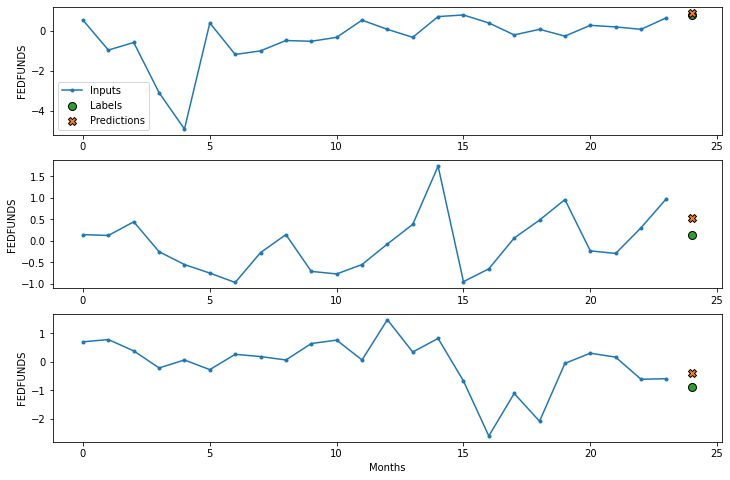

In [108]:
eval_window.plot(lstm_model, max_subplots = 3)
#wide_window.plot(lstm_model, max_subplots = 3)

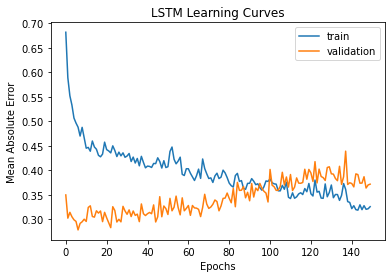

In [109]:
plt.plot(history_lstm.history['mean_absolute_error'])
plt.plot(history_lstm.history['val_mean_absolute_error'])
plt.title('LSTM Learning Curves')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

**Stacked Recurrent Neural Network: Stacked LTSM**

In [110]:
%%time

stacklstm_model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(64, activation = 'relu', kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1', recurrent_dropout = 0.2, return_sequences = True),
        tf.keras.layers.LSTM(12, activation = 'relu', kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1', recurrent_dropout = 0.2, return_sequences = False),
        tf.keras.layers.Dense(units = 8, kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1'),
        tf.keras.layers.Dense(units = 1),
        tf.keras.layers.Reshape([1, -1])
    ]
)

history_stacklstm = compile_and_fit(stacklstm_model, eval_window)

val_performance['StackLstm'] = stacklstm_model.evaluate(eval_window.val)
performance['StackLstm'] = stacklstm_model.evaluate(eval_window.test)

Epoch 1/150
10/10 [==============================] - 3s 55ms/step - loss: 28.0379 - mean_absolute_error: 0.6503 - val_loss: 24.8659 - val_mean_absolute_error: 0.2993
Epoch 2/150
10/10 [==============================] - 0s 22ms/step - loss: 24.3176 - mean_absolute_error: 0.6027 - val_loss: 21.6398 - val_mean_absolute_error: 0.3006
Epoch 3/150
10/10 [==============================] - 0s 22ms/step - loss: 21.2472 - mean_absolute_error: 0.5942 - val_loss: 18.7422 - val_mean_absolute_error: 0.2647
Epoch 4/150
10/10 [==============================] - 0s 22ms/step - loss: 18.5112 - mean_absolute_error: 0.5925 - val_loss: 16.1270 - val_mean_absolute_error: 0.2577
Epoch 5/150
10/10 [==============================] - 0s 22ms/step - loss: 16.0115 - mean_absolute_error: 0.5888 - val_loss: 13.7576 - val_mean_absolute_error: 0.2581
Epoch 6/150
10/10 [==============================] - 0s 22ms/step - loss: 13.7577 - mean_absolute_error: 0.5859 - val_loss: 11.6240 - val_mean_absolute_error: 0.2675
Epoc

10/10 [==============================] - 0s 23ms/step - loss: 1.6433 - mean_absolute_error: 0.4374 - val_loss: 1.4749 - val_mean_absolute_error: 0.3555
Epoch 51/150
10/10 [==============================] - 0s 22ms/step - loss: 1.6146 - mean_absolute_error: 0.4353 - val_loss: 1.5102 - val_mean_absolute_error: 0.3731
Epoch 52/150
10/10 [==============================] - 0s 22ms/step - loss: 1.5927 - mean_absolute_error: 0.4352 - val_loss: 1.4929 - val_mean_absolute_error: 0.3697
Epoch 53/150
10/10 [==============================] - 0s 22ms/step - loss: 1.5739 - mean_absolute_error: 0.4246 - val_loss: 1.5713 - val_mean_absolute_error: 0.3943
Epoch 54/150
10/10 [==============================] - 0s 22ms/step - loss: 1.5899 - mean_absolute_error: 0.4365 - val_loss: 1.4469 - val_mean_absolute_error: 0.3670
Epoch 55/150
10/10 [==============================] - 0s 22ms/step - loss: 1.5640 - mean_absolute_error: 0.4311 - val_loss: 1.4220 - val_mean_absolute_error: 0.3600
Epoch 56/150
10/10 [===

Epoch 100/150
10/10 [==============================] - 0s 22ms/step - loss: 1.0898 - mean_absolute_error: 0.4076 - val_loss: 1.1273 - val_mean_absolute_error: 0.4083
Epoch 101/150
10/10 [==============================] - 0s 22ms/step - loss: 1.1425 - mean_absolute_error: 0.4286 - val_loss: 1.0226 - val_mean_absolute_error: 0.3770
Epoch 102/150
10/10 [==============================] - 0s 22ms/step - loss: 1.1816 - mean_absolute_error: 0.4503 - val_loss: 1.2963 - val_mean_absolute_error: 0.4575
Epoch 103/150
10/10 [==============================] - 0s 22ms/step - loss: 1.1189 - mean_absolute_error: 0.4261 - val_loss: 1.0585 - val_mean_absolute_error: 0.3938
Epoch 104/150
10/10 [==============================] - 0s 22ms/step - loss: 1.0690 - mean_absolute_error: 0.4083 - val_loss: 1.1976 - val_mean_absolute_error: 0.4349
Epoch 105/150
10/10 [==============================] - 0s 22ms/step - loss: 1.0618 - mean_absolute_error: 0.4104 - val_loss: 1.0083 - val_mean_absolute_error: 0.3783
Epoc

10/10 [==============================] - 0s 22ms/step - loss: 0.8646 - mean_absolute_error: 0.3879 - val_loss: 1.1098 - val_mean_absolute_error: 0.4858
Epoch 150/150
3/3 [==============================] - 0s 4ms/step - loss: 0.9421 - mean_absolute_error: 0.3054
Wall time: 40.3 s


In [111]:
# With the LTSM using the return_sequence = False, the LSTM layer only return an output for the final layer as it enables the model to warm up. 
print('Input shape:', eval_window.example[0].shape)
print('Output shape:', stacklstm_model(eval_window.example[0]).shape)

Input shape: (48, 24, 127)
Output shape: (48, 1, 1)


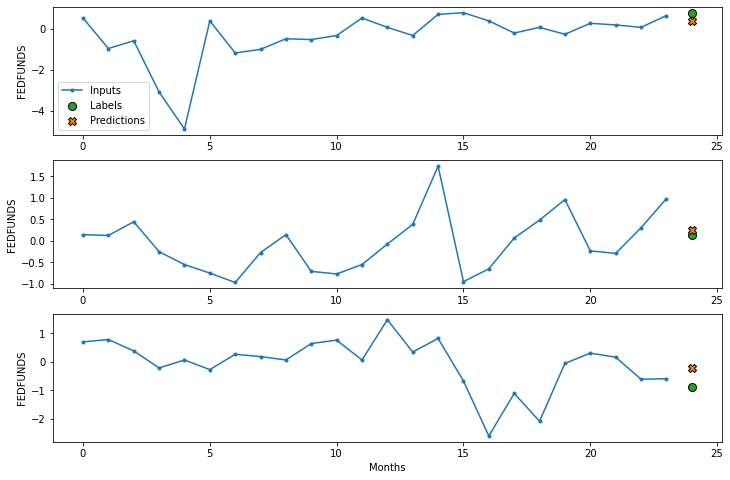

In [112]:
eval_window.plot(stacklstm_model, max_subplots = 3)

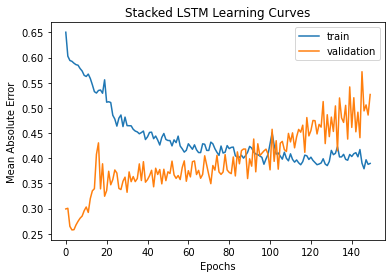

In [113]:
plt.plot(history_stacklstm.history['mean_absolute_error'])
plt.plot(history_stacklstm.history['val_mean_absolute_error'])
plt.title('Stacked LSTM Learning Curves')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

**Combining Neural Network: CNN + RNN(LSTM)**

In [114]:
conv_rnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters = 12, kernel_size = (CONV_WIDTH,), activation = "relu", kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1'),
        tf.keras.layers.LSTM(units = 64, activation = "relu", kernel_regularizer = 'L1', bias_regularizer = 'L1', activity_regularizer = 'L1', recurrent_dropout = 0.5, return_sequences = False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = 1),
        tf.keras.layers.Reshape([1, -1])
    ]
)

history_conv_rnn = compile_and_fit(conv_rnn_model, conv_window)

val_performance['Conv+RNN'] = conv_rnn_model.evaluate(eval_window.val)
performance['Conv+RNN'] = conv_rnn_model.evaluate(eval_window.test, verbose = 0)

Epoch 1/150
10/10 [==============================] - 2s 26ms/step - loss: 9.2125 - mean_absolute_error: 0.6444 - val_loss: 6.9804 - val_mean_absolute_error: 0.2891
Epoch 2/150
10/10 [==============================] - 0s 7ms/step - loss: 7.5975 - mean_absolute_error: 0.6411 - val_loss: 5.5203 - val_mean_absolute_error: 0.2865
Epoch 3/150
10/10 [==============================] - 0s 6ms/step - loss: 6.2461 - mean_absolute_error: 0.6367 - val_loss: 4.3065 - val_mean_absolute_error: 0.2831
Epoch 4/150
10/10 [==============================] - 0s 6ms/step - loss: 5.1373 - mean_absolute_error: 0.6358 - val_loss: 3.3150 - val_mean_absolute_error: 0.2819
Epoch 5/150
10/10 [==============================] - 0s 6ms/step - loss: 4.2565 - mean_absolute_error: 0.6324 - val_loss: 2.5775 - val_mean_absolute_error: 0.2784
Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 3.6159 - mean_absolute_error: 0.6285 - val_loss: 2.0815 - val_mean_absolute_error: 0.2768
Epoch 7/150
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: 0.9955 - mean_absolute_error: 0.3304 - val_loss: 0.9822 - val_mean_absolute_error: 0.3608
Epoch 52/150
10/10 [==============================] - 0s 6ms/step - loss: 0.9792 - mean_absolute_error: 0.3296 - val_loss: 0.9579 - val_mean_absolute_error: 0.3550
Epoch 53/150
10/10 [==============================] - 0s 6ms/step - loss: 0.9542 - mean_absolute_error: 0.3305 - val_loss: 0.9619 - val_mean_absolute_error: 0.3597
Epoch 54/150
10/10 [==============================] - 0s 6ms/step - loss: 0.9970 - mean_absolute_error: 0.3407 - val_loss: 0.9435 - val_mean_absolute_error: 0.3508
Epoch 55/150
10/10 [==============================] - 0s 6ms/step - loss: 0.9594 - mean_absolute_error: 0.3356 - val_loss: 0.9601 - val_mean_absolute_error: 0.3587
Epoch 56/150
10/10 [==============================] - 0s 6ms/step - loss: 1.0037 - mean_absolute_error: 0.3501 - val_loss: 0.9725 - val_mean_absolute_error: 0.3699
Epoch 57/150
10/10 [=========

10/10 [==============================] - 0s 6ms/step - loss: 0.6011 - mean_absolute_error: 0.2965 - val_loss: 0.7746 - val_mean_absolute_error: 0.4470
Epoch 102/150
10/10 [==============================] - 0s 6ms/step - loss: 0.6251 - mean_absolute_error: 0.3161 - val_loss: 0.7771 - val_mean_absolute_error: 0.4647
Epoch 103/150
10/10 [==============================] - 0s 6ms/step - loss: 0.5735 - mean_absolute_error: 0.2936 - val_loss: 0.7943 - val_mean_absolute_error: 0.4635
Epoch 104/150
10/10 [==============================] - 0s 6ms/step - loss: 0.5941 - mean_absolute_error: 0.2936 - val_loss: 0.7671 - val_mean_absolute_error: 0.4433
Epoch 105/150
10/10 [==============================] - 0s 6ms/step - loss: 0.6206 - mean_absolute_error: 0.3000 - val_loss: 0.8227 - val_mean_absolute_error: 0.4637
Epoch 106/150
10/10 [==============================] - 0s 6ms/step - loss: 0.6057 - mean_absolute_error: 0.3003 - val_loss: 0.7979 - val_mean_absolute_error: 0.4565
Epoch 107/150
10/10 [===

3/3 [==============================] - 0s 2ms/step - loss: 1.9116 - mean_absolute_error: 0.7960


In [115]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_rnn_model(conv_window.example[0]).shape)

Input shape: (48, 12, 127)
Output shape: (48, 1, 1)


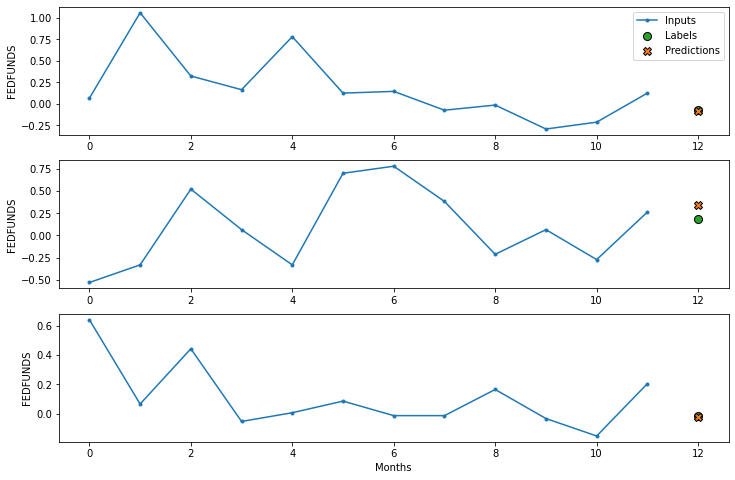

In [116]:
conv_window.plot(conv_rnn_model, max_subplots = 3)

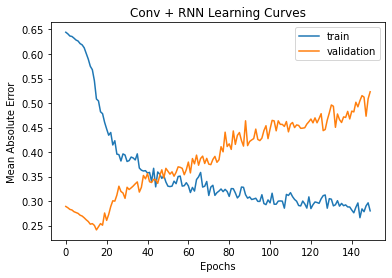

In [117]:
plt.plot(history_conv_rnn.history['mean_absolute_error'])
plt.plot(history_conv_rnn.history['val_mean_absolute_error'])
plt.title('Conv + RNN Learning Curves')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

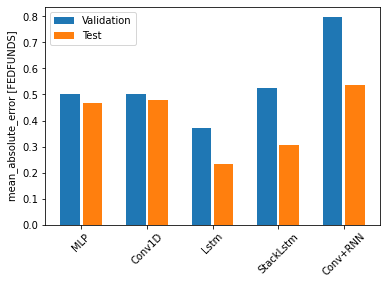

In [118]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = conv_rnn_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [FEDFUNDS]')
plt.bar(x - 0.17, val_mae, width, label = 'Validation')
plt.bar(x + 0.17, test_mae, width, label = 'Test')
plt.xticks(ticks = x, labels = performance.keys(),
           rotation = 45)
_ = plt.legend()

As we can observe from the bar plot, the LSTM model seems to peform the best between the estimated neural network models. This comment is made after running the code section for all of the neural network models 3 times (given the nature of the neural networks, doing only 1 run might be misleading), and the LSTM remains as one the one with the lowest mean absolute error. It should be noted, however, that the variance in the results from the Stacked LSTM and Conv + RNN model is persistent, most likely due to the overfitting of the model.

***Section 3: Conclusions and further work***

One of the first conclusions is that, when comparing the performance of statistical models, the Lasso Regression showed a better performance than the Ridge and Random Forest regressions in terms of mean absolute error. For the specific case of the Lasso Regression, I find that from 126 features, only 10 were not set to 0 given the L1 norm penalty. More specifically, the (negative) mean absolute error of the lasso regresion is 0.3754 (rounded to 4 decimals) in the validation set.

Regarding the Neural Network models, we find some particularly interesting results:

First, as it is known, given the nature of the deep learning algorithms, each time we compile and fit the neural networks the output will change slightly. Specifically, for the case of the Stacked LSTM and Conv + RNN neural network models, the outputs for each run of the jupyter notebook showed the most variance. In constrast, the results for the Multi Step MLP, Conv1D and the LSTM wre more stable. Taking this into account, two results are to be pointed out:
- From the estimated Neural Network models, the LSTM is the one that consistently reports the lowest mean absolute error, both in the validation and test sets. In addition, the mean absolute error of the LSTM tends to be slightly lower than that of the Lasso Regression, although the comparison might be slightly biased as the Cross Validation parameter for the Lasso was of 5 while the batches established in the WindowGenerator class were 48.
- Without including explicit regularization features, all of the neural network models tend to overfit. After including a set of regularization features, the MLP, Conv1D and LSTM tend to show more auspicious results in terms of the learning process. However, the Stacked LSTM and Conv + RNN continue to overfit considerably, and the learning curve process for both does vary with each run of the jupiter notebook.

One possible interpretation for the latter result is that, for this particular dataset split between train and validation, there might be missrepresentation in the sense that the validation set might contain too few examples compared to the training set, which would limit the ability of the model to generalize. In this case, my approach was to add further regularization components to the models (kernels, bias, activations, dropouts), but even then overfitting was not completely dealt with.

In terms of the Data Processing section, a comment could be made in the following sense regarding outlier values: no treatment was made to deal with outlier values. This was because of two reasons:
- In the work from Paranhos (2021) no explicit mention is made on how to deal with outlier values. Intuitively, the neural networks should still be able to handle outlier values and determine when to learn from them or not given a specific model structure, even if it would be prefered to have compltely homogenized data in order to attain better performance.
- Intuitively, treating outliers in specific ways requires of some thought when dealing with time series. A potential option for dealing with outliers was to replace them with NaN values, which would then be converted to unconditional means based on the transformations carried out (this is common when using this dataset to estimate dynamic factor models as seen in the literature). Removing or replacing the value of a specific observation in a time series should not be taken for granted as it alterates the intertemporal dependence of the timeseries. In such sense, I did opt to not include a function to remove outliers, which could potentially have an impact in the learning process of the neural networks.
A potential exercise could be including a function to remove and deal with outliers and then repeat the exercise, although I believe there is no reason to think that major gains could come from that approach.

In terms of the Models and Application section, I recognize that the overfitting was not particularly solved in the neural network models, in particular with the Stacked LSTM and Conv + RNN model. Despite not being included in the code, several different structures for each model were attempted in order to solve the problem. For instance, in some models a Dropout Layer was included, in some models more regularization parameteres on the Dense and LSTM models were included, and so on. The innability to appropiately account for the overfitting problem limited my ability to perform a detailed hyperparameter tuning for all of the neural network models (i.e., grid search after using KerasCompiler with different optimizers, maximum epochs, batch sizes and so on). This can be considered further work in order to enrich the contrast between the statistical and neural network models (as I did carry out a gridsearch for the statistical ones but not for the neural network ones).

In terms of further work, two direct ideas could be carried out:
1. Extending the analysis of the neural networks to a multi-output approach. For instance, it could be also interesting to forecast movements in employment and inflation data as well as the monetary policy rate. This can be carried out by properly defining the last layer of the neural networks to have the desired number of outputs, as well as establishing the label columns in the WindowGenerator class to the desired output variables.
2. An interesting approach could be reframing the problem into a categorical one. In practical terms, the US Federal Reserve makes two decisions, one conditional on the other: whether to move or not the monetary policy window (along which the effective rate fluctuates), and, if it does move it, by how much. This practical discreteness enables a scheme in which one could, for instance, redefine the target variable accoridng to the following rule: 1 if the range is increased, 0 if there is no movement, and -1 if the range is lowered. This enables the possibility to reframe the statistical models and neural networks into a classification problem, with the appropiate adjustments to the activation functions, for instance. A second extension could then be to model by how much do the changes ocurr. This framework is more practical for monetary policy monitoring and forecasting as an economic analyst.
Both of these approaches could yield interesting results in real-world employment opportunities as a macroeconomic analyst.

**Bibliography and relevant links**

McCracken & Ng (2016) - https://econpapers.repec.org/article/tafjnlbes/v_3a34_3ay_3a2016_3ai_3a4_3ap_3a574-589.htm

Paranhos (2021) - https://ideas.repec.org/p/wrk/warwec/1344.html

TensorFlow Tutorials - https://www.tensorflow.org/tutorials/structured_data/time_series